# On average, do males or females spend more money per order? With or without discount.

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as scs
from scipy import stats 
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import sqlite3

In [2]:
conn = sqlite3.connect("./Northwind_small.sqlite")
cursor = conn.cursor()

In [24]:
query = '''SELECT c.ID AS CustomerID, c.ContactName, o.ID AS OrderID, od.UnitPrice, od.Quantity, od.Discount
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderID = o.ID
                            JOIN Customer c ON o.CustomerID = c.ID
                            '''
df2 = pd.read_sql(query, conn)

df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 6 columns):
CustomerID     2078 non-null object
ContactName    2078 non-null object
OrderID        2078 non-null int64
UnitPrice      2078 non-null float64
Quantity       2078 non-null int64
Discount       2078 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 97.5+ KB


,CustomerID,ContactName,OrderID,UnitPrice,Quantity,Discount
0,VINET,Paul Henriot,10248,14.0,12,0.0
1,VINET,Paul Henriot,10248,9.8,10,0.0
2,VINET,Paul Henriot,10248,34.8,5,0.0
3,TOMSP,Karin Josephs,10249,18.6,9,0.0
4,TOMSP,Karin Josephs,10249,42.4,40,0.0


In [4]:
df2.ContactName.unique()

array(['Paul Henriot', 'Karin Josephs', 'Mario Pontes', 'Mary Saveley',
       'Pascale Cartrain', 'Yang Wang', 'Michael Holz', 'Paula Parente',
       'Carlos Hernández', 'Roland Mendel', 'Francisco Chang',
       'Henriette Pfalzheim', 'Bernardo Batista', 'Paula Wilson',
       'Maria Larsson', 'Frédérique Citeaux', 'Pirkko Koskitalo',
       'Peter Franken', 'Manuel Pereira', 'Karl Jablonski',
       'Art Braunschweiger', 'Horst Kloss', 'Giovanni Rovelli',
       'Miguel Angel Paolino', 'Alexander Feuer', 'Christina Berglund',
       'Renate Messner', 'Alejandra Camino', 'Carlos González',
       'Janete Limeira', 'Maurizio Moroni', 'Victoria Ashworth',
       'Pedro Afonso', 'Anabela Domingues', 'Patricia McKenna',
       'Rita Müller', 'José Pedro Freyre', 'Rene Phillips', 'Fran Wilson',
       'Ana Trujillo', 'Liz Nixon', 'Helen Bennett',
       'Guillermo Fernández', 'Philip Cramer', 'Jose Pavarotti',
       'Martín Sommer', 'Lino Rodriguez', 'Laurence Lebihan',
       'Jean Fre

In [5]:
females = ['Karin Josephs','Mary Saveley','Paula Parente','Henriette Pfalzheim',
          'Paula Wilson','Maria Larsson','Christina Berglund','Renate Messner', 
           'Alejandra Camino','Janete Limeira','Victoria Ashworth','Anabela Domingues', 
           'Patricia McKenna','Rita Müller','Ana Trujillo', 'Liz Nixon', 'Helen Bennett',
          'Isabel de Castro', 'Jytte Petersen','Aria Cruz', 'Annette Roulet',
          'Ann Devon','Elizabeth Lincoln','Martine Rancé','Elizabeth Brown',
          'Hanna Moos','Catherine Dewey']
df2['Gender'] = np.where(df2['ContactName'].isin(females), 'female', 'male')
df2.head()

,CustomerID,ContactName,OrderID,UnitPrice,Quantity,Discount,Gender
0,VINET,Paul Henriot,10248,14.0,12,0.0,male
1,VINET,Paul Henriot,10248,9.8,10,0.0,male
2,VINET,Paul Henriot,10248,34.8,5,0.0,male
3,TOMSP,Karin Josephs,10249,18.6,9,0.0,female
4,TOMSP,Karin Josephs,10249,42.4,40,0.0,female


In [6]:
# Now that I grouped the customers by gender to create a new column,
# I can begin to explore which gender spends the most money per order.


In [21]:
# First, I need to define and calculate the total price of each order and create a new column called "TotalOrderPrice"
# --> TotalOrderPrice = (Quantity * UnitPrice)

# Then, I need to define and calculate the discounted order price and create a new column called "NetPrice"
# --> NetPrice = [TotalOrderPrice - (TotalOrderPrice * Discount)] 

df2['TotalOrderPrice'] = np.multiply(df2['Quantity'],df2['UnitPrice'])
df2['NetPrice'] = np.multiply(df2['TotalOrderPrice'],df2['Discount'])
df2['NetPrice'] = np.subtract(df2['TotalOrderPrice'],df2['NetPrice'])
df2.head()

,CustomerID,ContactName,OrderID,UnitPrice,Quantity,Discount,Gender,TotalOrderPrice,NetPrice
0,VINET,Paul Henriot,10248,14.0,12,0.0,male,168.0,168.0
1,VINET,Paul Henriot,10248,9.8,10,0.0,male,98.0,98.0
2,VINET,Paul Henriot,10248,34.8,5,0.0,male,174.0,174.0
3,TOMSP,Karin Josephs,10249,18.6,9,0.0,female,167.4,167.4
4,TOMSP,Karin Josephs,10249,42.4,40,0.0,female,1696.0,1696.0


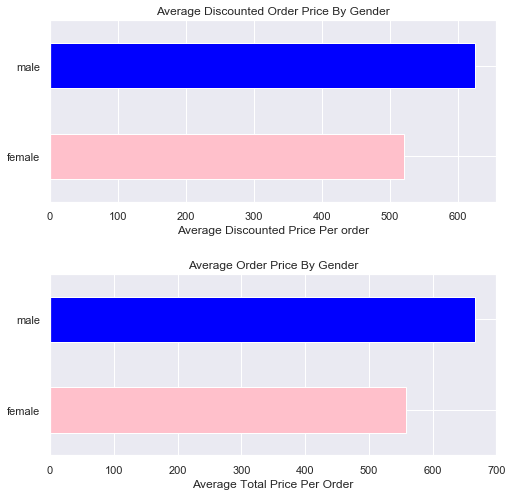

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

df2.groupby(['Gender'])['NetPrice'].mean().plot(kind='barh', color=['pink','blue'], ax=ax1)
df2.groupby(['Gender'])['TotalOrderPrice'].mean().plot(kind='barh', color=['pink','blue'], ax=ax2)

ax1.set_title('Average Discounted Order Price By Gender')
ax1.set_ylabel('')
ax1.set_xlabel('Average Discounted Price Per order')

ax2.set_title('Average Order Price By Gender')
ax2.set_ylabel('')
ax2.set_xlabel('Average Total Price Per Order')
fig.subplots_adjust(hspace=0.4);

In [9]:
df2_male = df2.loc[df2['Gender'] == 'male']
df2_male.describe()

,OrderID,UnitPrice,Quantity,Discount,TotalOrderPrice,NetPrice
count,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000
mean,10663.552782,26.605136,25.711840,0.052211,666.563395,624.847798
std,237.369117,31.427471,20.761993,0.079448,1074.097228,1005.617736
min,10248.000000,2.000000,1.000000,0.000000,12.500000,12.500000
25%,10461.000000,12.000000,10.000000,0.000000,172.800000,162.187500
50%,10674.000000,18.400000,20.000000,0.000000,380.000000,368.062500
75%,10861.000000,32.800000,35.000000,0.100000,760.000000,720.000000
max,11076.000000,263.500000,130.000000,0.250000,15810.000000,15810.000000


In [10]:
df2_female = df2.loc[df2['Gender'] == 'female']
df2_female.describe()

,OrderID,UnitPrice,Quantity,Discount,TotalOrderPrice,NetPrice
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,10647.640533,25.597737,20.217456,0.063964,557.868580,520.619604
std,252.270054,26.678301,14.611261,0.090660,953.217572,906.215718
min,10249.000000,2.000000,1.000000,0.000000,4.800000,4.800000
25%,10431.000000,12.000000,10.000000,0.000000,125.700000,116.700000
50%,10622.000000,19.000000,18.000000,0.000000,310.600000,289.900000
75%,10857.000000,31.230000,30.000000,0.100000,625.800000,576.900000
max,11077.000000,263.500000,80.000000,0.250000,10540.000000,10540.000000


# EXPLAIN WHY AM I USING VIOLIN PLOT

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


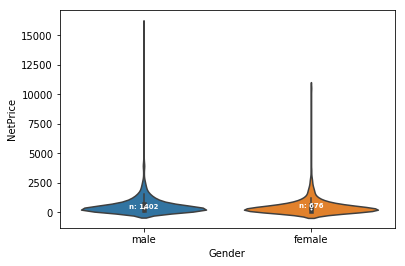

In [12]:
# Next I want to plot and visualize this relationship.

ax = sns.violinplot(x="Gender", y="NetPrice", data=df2)

medians = df2.groupby(['Gender'])['NetPrice'].median().values
nobs = df2['Gender'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], horizontalalignment='center', size='x-small', color='w', weight='semibold')

In [25]:
# Reference - "https://python-graph-gallery.com/58-show-number-of-observation-on-violinplot/"

# Statistical Analysis

## Hypothesis 3

### h0: mu_male = mu_females
#No difference in money spent on purchases by Males & Females 
### ha: mu_male $\neq$ mu_females
#Males spent the most money on purchases

In [13]:
# Let's run a One sample t-test

# List My Assumptions:
# Data is Normal Distribution 
# Data is Randomly Sampled
# Data is Independent


In [14]:
def one_sample_ttest(sample, popmean, alpha):

    # Use eye test on distribution to check for normality 
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(12,10)})
    sns.distplot(sample)
    
    # Population mean 
    mu = popmean
    
    # Sample mean (x̄) using NumPy mean()
    x_bar= sample.mean()

    # std dev of our sample
    sigma = np.std(sample)
    
    # DF
    df = len(sample) - 1
    
    #Find critical t-value
    t_crit = stats.t.ppf(1 - alpha, df=df)
    
    #Find p-value and t-value
    results = stats.ttest_1samp(a= sample, popmean= mu)         
    
    if (results[0]>t_crit) and (results[1]<alpha):
        print ("We reject the null hypothesis. Results are statistically significant with t-value =", 
                round(results[0], 2), "critical t-value =", t_crit, "and p-value =", np.round((results[1]), 6))
    else:
        print ("We fail to reject the null hypothesis with a t-value =", 
                round(results[0], 2), ", critical t-value =", t_crit, "and p-value =", np.round((results[1]), 6))

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


We reject the null hypothesis. Results are statistically significant with t-value = 3.88 critical t-value = 1.6459419805240438 and p-value = 0.000109


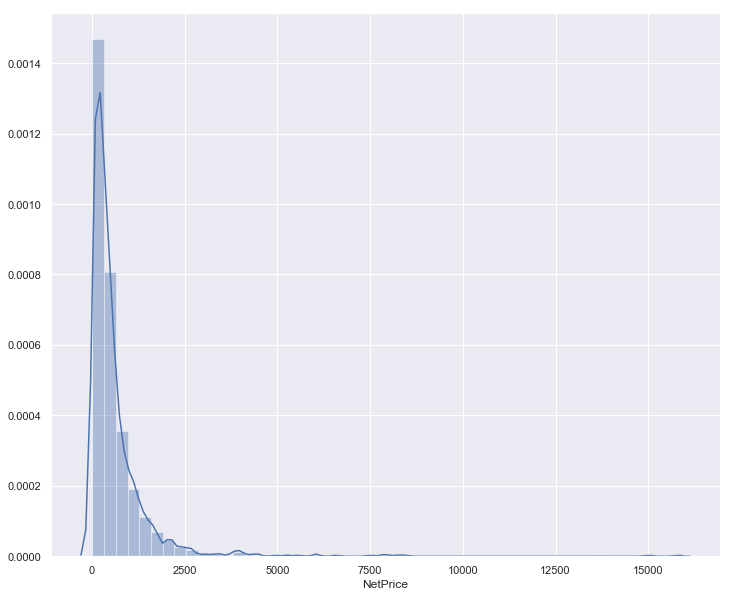

In [15]:
sample2 = df2_male.NetPrice
popmean2 = df2_female.NetPrice.mean()
alpha = 0.05
one_sample_ttest(sample2, popmean2, alpha)

In [16]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled variance threshold 
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's D
    d = diff / np.sqrt(pooled_var)
    
    return d

In [17]:
males = df2_male.NetPrice
females = df2_female.NetPrice
Cohen_d(males, females)
# effect size is small with a value of ~.10

0.10696714636059383

# Conclusion

In [26]:
# Males spend more money on their orders than females for both discounted and non-discounted orders!
# Not the result I would have expected!

# We reject the null hypothesis and conclude that males spend more money per order than females.
# By rejecting the null hypothesis, we are saying that there is a difference in money spent on purchases by gender.

# I wonder if males order more items than females?